In [9]:
"""
Check how well we can fit Laplace distribution to the S&P 500 market returns. How does the variance depend on time?
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load data

In [4]:
data = pd.read_csv('SPX.csv', parse_dates = ['Date'], index_col = 0)

data['Pct_change'] = data['Adj Close'].pct_change()   # p2/p1 - 1
data['Log_change'] = np.log(1 + data['Pct_change'])    # Log(p2/p1)

print(data.head())

dx = 0.001

                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0   
1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0   
1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0   
1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0   
1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0   

            Pct_change  Log_change  
Date                                
1927-12-30         NaN         NaN  
1928-01-03    0.005663    0.005647  
1928-01-04   -0.002252   -0.002255  
1928-01-05   -0.009594   -0.009640  
1928-01-06    0.006268    0.006248  


# Fit Laplace distribution

In [48]:
def minus_log_likelihood(p, x):
    """
    Given the observed log returns x, what is negative log likelihood as a function of the Laplace distribution
    paremeters mu and b? See https://en.wikipedia.org/wiki/Laplace_distribution
    """
    mu, b = p
    b = np.abs(b)
    return np.sum(np.abs(x-mu)/b + np.log(b))

def laplace_distribution(x, mu, b):
    return np.exp(-np.abs(x-mu)/np.abs(b))/2/np.abs(b)

In [51]:
fit_coef = minimize(minus_log_likelihood, [0,0.01], data['Log_change']).x

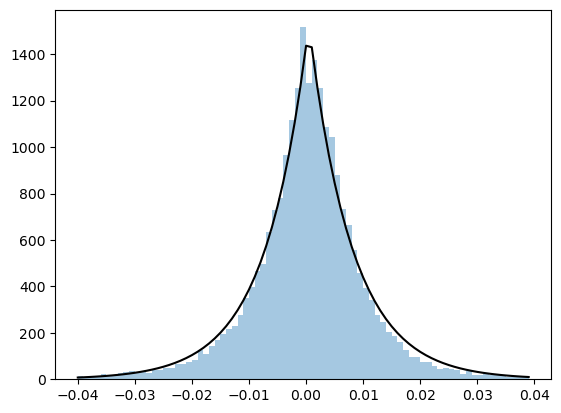

In [52]:
x = np.arange(-0.04, 0.04, dx)
plt.hist(data['Log_change'], x, alpha = 0.4)
norm = dx * len(data)
plt.plot(x, norm * laplace_distribution(x, *fit_coef), c = 'k')

# Longer periods of time?

In [65]:
def plot_n_day(n, plot_range, title):
    subsample = data[::n].copy()
    subsample['Pct_change'] = subsample['Adj Close'].pct_change()   # p2/p1 - 1
    subsample['Log_change'] = np.log(1 + subsample['Pct_change'])    # Log(p2/p1)

    fit_coef = minimize(minus_log_likelihood, [0,0.01], subsample['Log_change']).x

    x = np.arange(-plot_range, plot_range, dx)
    plt.hist(subsample['Log_change'], x, alpha = 0.4)
    norm = len(subsample)*dx
    plt.plot(x, norm * laplace_distribution(x, *fit_coef), c = 'k')
    plt.title(title);
    plt.xlabel('$\log(p_{t+n}/p_t)$')

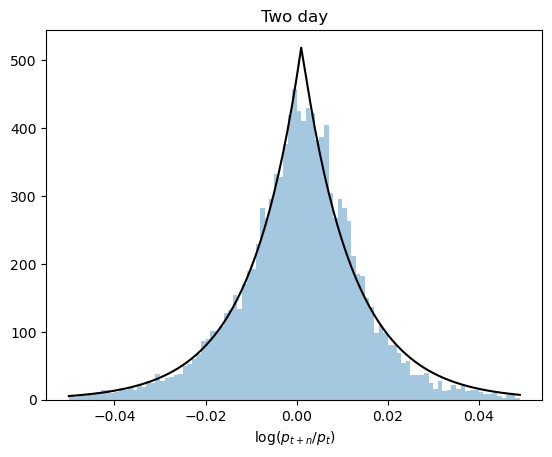

In [66]:
plot_n_day(2, 0.05, 'Two day')

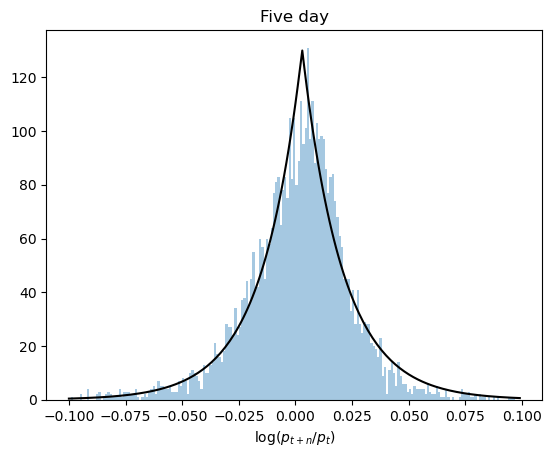

In [67]:
plot_n_day(5, 0.1, 'Five day')

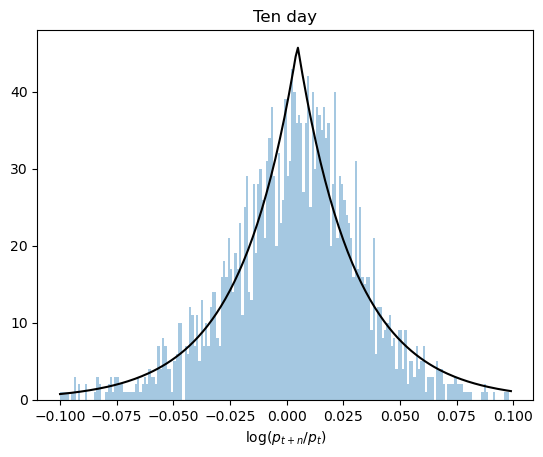

In [69]:
plot_n_day(10, 0.1, 'Ten day')

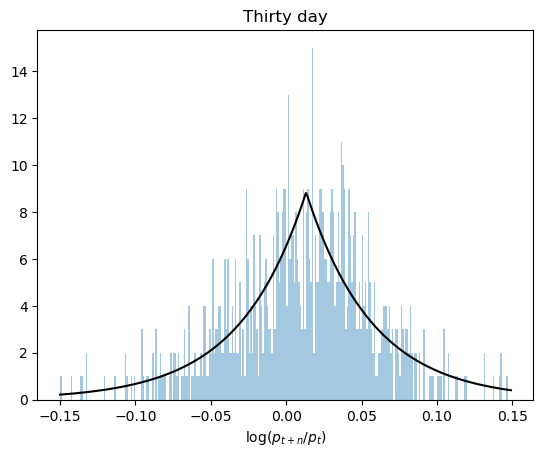

In [70]:
plot_n_day(30, 0.15, 'Thirty day')

Fits better than the Gaussian

# Variance as a function of time

In [71]:
def n_day_variance(n):
    subsample = data[::n].copy()
    subsample['Pct_change'] = subsample['Adj Close'].pct_change()   # p2/p1 - 1
    subsample['Log_change'] = np.log(1 + subsample['Pct_change'])    # Log(p2/p1)

    mu, b = minimize(minus_log_likelihood, [0,0.01], subsample['Log_change']).x

    return 2*b**2

In [72]:
# find variance of log returns for 1, 2, ... 30 day long periods
time = np.arange(1,30)
var = [n_day_variance(x) for x in time]

In [73]:
# Fit the expected linear dependence
def f(x, p):
    return x*p

fit_coef = curve_fit(f, time, var, p0 = 0.01)[0][0]

print(fit_coef)

0.0001318851634888252


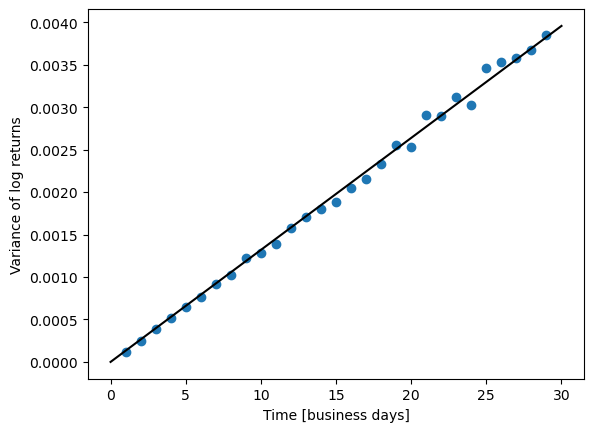

In [74]:
# Plot the results
plt.scatter(time, var)
plt.plot([0,30], [0, 30*fit_coef], color = 'k')
plt.xlabel('Time [business days]')
plt.ylabel('Variance of log returns');